In [1]:
import pandas as pd
import numpy as np
import math
import requests
from bs4 import BeautifulSoup
from bs4 import Comment
from time import sleep
import pandas as pd
import numpy as np
import math
import requests
from bs4 import BeautifulSoup
from bs4 import Comment

In [2]:
import pandas as pd
import numpy as np
import math
import requests
from bs4 import BeautifulSoup
from bs4 import Comment
boxscores = []

In [4]:
plays = pd.read_csv('MLBPlayData.csv').drop('Unnamed: 0', axis=1)

to change: 
- column 9: change to two columns, with batting team's runs and opponent team's runs
- column 11: parse to three variables, curr_man_on_first, curr_man_on_second, curr_man_on_third
- column 12: parse to three variables, number of pitches in at bat, number of balls in at bat, number of strikes in at bat 
- column 13: parse to two variables for number of runs and number of outs
- column 19: parse for was_out, was_single, was_double, was_triple, was_homerun, was_strikeout, was_groundout, was_error ??, 

In [5]:
plays.columns = ['gameID', 'date', 'stadium', 'attendance', 'inning', 'starting_pitcher', 
                 'is_starting_pitcher', 'is_away', 'batting_position', 'score', 'num_outs', 
                 'runners_on_base', 'pitch_details', 'run_out_result', 'team_at_bat', 'batter', 'pitcher', 
                 'WEC', 'wWE', 'play_description', 'team_won']
plays.head()

,gameID,date,stadium,attendance,inning,starting_pitcher,is_starting_pitcher,is_away,batting_position,score,...,runners_on_base,pitch_details,run_out_result,team_at_bat,batter,pitcher,WEC,wWE,play_description,team_won
0,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,1,0-0,...,---,"5,(1-2) CFBFX",NaN,TOR,Reed Johnson,Joe Saunders,-6%,44%,Double to CF (Fly Ball to Deep CF),0
1,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,2,0-0,...,-2-,"6,(3-2) FBFBBX",O,TOR,Aaron Hill,Joe Saunders,4%,48%,Lineout: 3B,0
2,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,3,0-0,...,-2-,"2,(1-0) *BX",RO,TOR,Vernon Wells,Joe Saunders,-4%,44%,Single to RF (Line Drive); Johnson Scores; out...,0
3,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,4,1-0,...,---,"2,(0-1) CX",O,TOR,Troy Glaus,Joe Saunders,1%,45%,Lineout: 3B-1B,0
4,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,A.J. Burnett,1,0,1,0-1,...,---,"4,(1-2) BCCX",NaN,LAA,Maicer Izturis,A.J. Burnett,4%,49%,Single to 1B (Ground Ball),1


In [6]:
plays_raw = plays.copy()

In [7]:
plays['runs_in_atbat'] = [0 if type(row)==float else row.count('R') for row in plays['run_out_result']]
plays['outs_in_atbat'] = [0 if type(row)==float else row.count('O') for row in plays['run_out_result']]

plays['runner_on_first']= [0 if runner[0]=='-' else 1 for runner in plays['runners_on_base']]
plays['runner_on_second']= [0 if runner[1]=='-' else 1 for runner in plays['runners_on_base']]
plays['runner_on_third']= [0 if runner[2]=='-' else 1 for runner in plays['runners_on_base']]

plays['batting_team_runs'] = [score.split('-')[0] for score in plays['score']]
plays['fielding_team_runs'] = [score.split('-')[1] for score in plays['score']]

plays["pitch_count"] = [pitch.split(',')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]
plays["ball_count"] = [pitch.split('(')[1].split('-')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]
plays["strike_count"] = [pitch.split('(')[1].split('-')[1].split(')')[0] if isinstance(pitch,str) else None for pitch in plays['pitch_details']]

plays["is_single"] = ['Single' in play for play in plays['play_description']]
plays["is_double"] = ['Double' in play for play in plays['play_description']]
plays["is_triple"] = ['Triple' in play for play in plays['play_description']]
plays["is_homerun"] = ['Homerun' in play for play in plays['play_description']]
plays["is_strikeout"] = ['Strikeout' in play for play in plays['play_description']]
plays["is_groundout"] = ['Groundout' in play for play in plays['play_description']]
plays["is_walk"] = ['Walk' in play for play in plays['play_description']]
plays["is_steal"] = [('Steal' or 'Steals' or 'steal' or 'steals') in play for play in plays['play_description']]

plays['batting_team_runs'] = plays['batting_team_runs'].apply(lambda x: int(x))
plays['fielding_team_runs'] = plays['fielding_team_runs'].apply(lambda x: int(x))
plays['run_dif']= plays['batting_team_runs'] - plays['fielding_team_runs']

plays['wWE'] = plays['wWE'].apply(lambda x: int(x.replace("%","")))

plays = plays.drop(['run_out_result','runners_on_base', 'pitch_details', 'play_description'], axis=1)

plays

,gameID,date,stadium,attendance,inning,starting_pitcher,is_starting_pitcher,is_away,batting_position,score,...,strike_count,is_single,is_double,is_triple,is_homerun,is_strikeout,is_groundout,is_walk,is_steal,run_dif
0,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,1,0-0,...,2,False,True,False,False,False,False,False,False,0
1,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,2,0-0,...,2,False,False,False,False,False,False,False,False,0
2,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,3,0-0,...,0,True,False,False,False,False,False,False,False,0
3,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,Joe Saunders,1,1,4,1-0,...,1,False,False,False,False,False,False,False,False,1
4,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,A.J. Burnett,1,0,1,0-1,...,2,True,False,False,False,False,False,False,False,-1
5,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,A.J. Burnett,1,0,2,0-1,...,2,True,False,False,False,False,False,False,False,-1
6,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,A.J. Burnett,1,0,3,0-1,...,0,False,True,False,False,False,False,False,False,-1
7,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",1,A.J. Burnett,1,0,4,0-1,...,0,False,False,False,False,False,False,False,False,-1
8,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",2,Joe Saunders,1,1,5,1-0,...,2,False,False,False,False,False,False,False,False,1
9,1,"Friday, September 8, 2006",Angel Stadium of Anaheim,"42,259",2,Joe Saunders,1,1,6,1-0,...,2,False,True,False,False,False,False,False,False,1


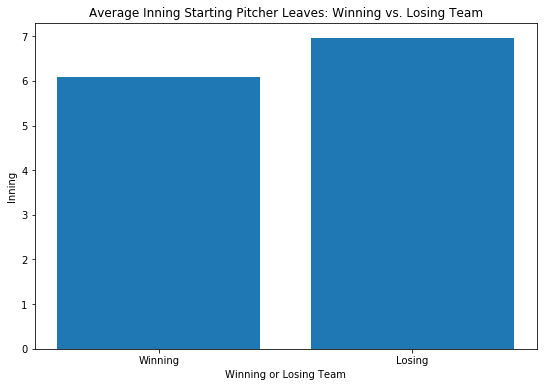

In [8]:
import matplotlib
import matplotlib.pyplot as plt

winning_df = plays.loc[plays['team_won']==1]
losing_df = plays.loc[plays['team_won']==0]

winning_nonstarter = winning_df.loc[winning_df['is_starting_pitcher']==0]
losing_nonstarter = losing_df.loc[losing_df['is_starting_pitcher']==0]

winning_nonstarter = winning_nonstarter.drop_duplicates(subset='gameID', keep='first')
losing_nonstarter = losing_nonstarter.drop_duplicates(subset='gameID', keep='first')

winning_avg_nonstarter_inning = np.mean(winning_nonstarter['inning'])
losing_avg_nonstarter_inning = np.mean(losing_nonstarter['inning'])

fig, ax = plt.subplots(figsize=(9,6))
ax.bar([1,2], [winning_avg_nonstarter_inning, losing_avg_nonstarter_inning], tick_label=['Winning', 'Losing'])
ax.set_ylabel('Inning')
ax.set_xlabel('Winning or Losing Team')
ax.set_title('Average Inning Starting Pitcher Leaves: Winning vs. Losing Team')
plt.show()

[50.927874907658214, 59.789439374185136, 54.302051594556168, 56.044411908247923, 51.957037874505367, 52.872322899505768, 52.587276550998951, 56.274834437086092]


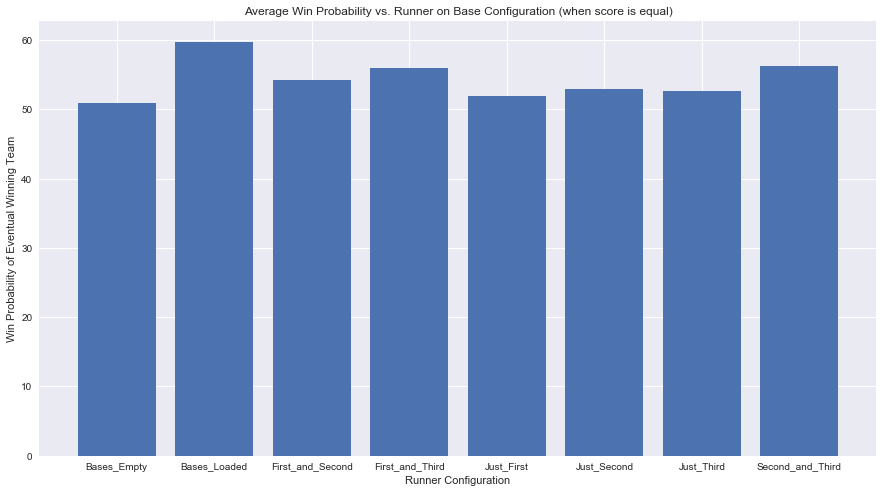

In [108]:
same_score_df = plays.loc[plays['run_dif']==0]

bases_empty = same_score_df.loc[(same_score_df['runner_on_first']==0) &
                               (same_score_df['runner_on_second']==0) & (same_score_df['runner_on_third']==0)]
just_first = same_score_df.loc[(same_score_df['runner_on_first']==1) & 
                               (same_score_df['runner_on_second']==0) & (same_score_df['runner_on_third']==0)]
just_second = same_score_df.loc[(same_score_df['runner_on_first']==0) & 
                               (same_score_df['runner_on_second']==1) & (same_score_df['runner_on_third']==0)]
just_third = same_score_df.loc[(same_score_df['runner_on_first']==0) & 
                               (same_score_df['runner_on_second']==0) & (same_score_df['runner_on_third']==1)]
first_second = same_score_df.loc[(same_score_df['runner_on_first']==1) & 
                               (same_score_df['runner_on_second']==1) & (same_score_df['runner_on_third']==0)]
second_third = same_score_df.loc[(same_score_df['runner_on_first']==0) & 
                               (same_score_df['runner_on_second']==1) & (same_score_df['runner_on_third']==1)]
first_third = same_score_df.loc[(same_score_df['runner_on_first']==1) & 
                               (same_score_df['runner_on_second']==0) & (same_score_df['runner_on_third']==1)]
bases_loaded = same_score_df.loc[(same_score_df['runner_on_first']==1) & 
                               (same_score_df['runner_on_second']==1) & (same_score_df['runner_on_third']==1)]

runners_win_prob = {}
runners_win_prob['Bases_Empty']= np.mean(bases_empty['wWE'])
runners_win_prob['Just_First']= np.mean(just_first['wWE'])
runners_win_prob['Just_Second']= np.mean(just_second['wWE'])
runners_win_prob['Just_Third']= np.mean(just_third['wWE'])
runners_win_prob['First_and_Second']= np.mean(first_second['wWE'])
runners_win_prob['First_and_Third']= np.mean(first_third['wWE'])
runners_win_prob['Second_and_Third']= np.mean(second_third['wWE'])
runners_win_prob['Bases_Loaded']= np.mean(bases_loaded['wWE'])

result_list = sorted([[k, v] for k, v in runners_win_prob.items()], key = lambda x: x[0])

runners = [x[0] for x in result_list]
win_prob = [x[1] for x in result_list]

fig, ax = plt.subplots(figsize=(15,8))
ax.bar(range(8), win_prob, tick_label=runners)
ax.set_ylabel('Win Probability of Eventual Winning Team')
ax.set_xlabel('Runner Configuration')
ax.set_title('Average Win Probability vs. Runner on Base Configuration (when score is equal)')
plt.show()

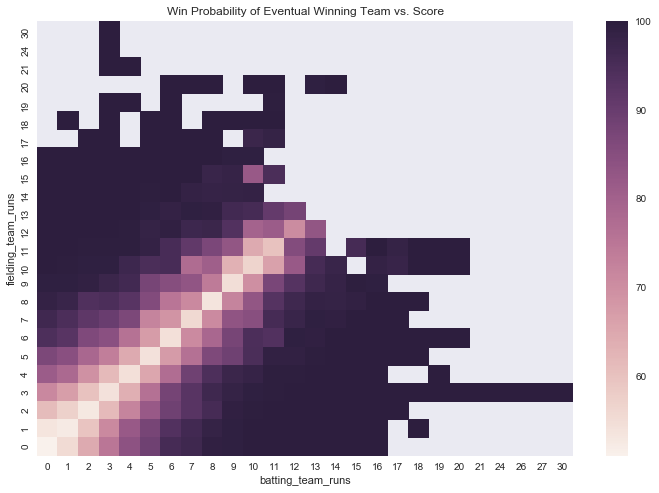

In [100]:
import seaborn as sns

win_prob_by_score = pd.pivot_table(plays, values='wWE', index=['fielding_team_runs'], columns=['batting_team_runs'])
win_prob_by_score
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(win_prob_by_score)
ax.invert_yaxis()
ax.set_title('Win Probability of Eventual Winning Team vs. Score')
plt.show()

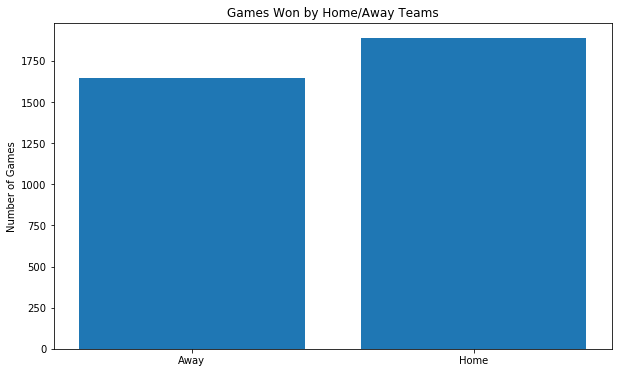

In [10]:
plays['home_team_won'] = np.where(plays['team_won'] == plays['is_away'], 0, 1)

plays_first_play = plays.drop_duplicates(subset='gameID', keep='first')
plays_last_play = plays.drop_duplicates(subset='gameID', keep='last')

by_home_away = plays_last_play.groupby('home_team_won').size()

fig, ax = plt.subplots(figsize=(10,6))
ax.bar([0,1], by_home_away)
ax.set_xticks([0,1])
ax.set_xticklabels(['Away', 'Home'])
ax.set_title('Games Won by Home/Away Teams')
ax.set_ylabel('Number of Games')
plt.show()

In [13]:
rows=[]
for i in range(1, len(plays['gameID'])):
    if (plays['gameID'][i] != plays['gameID'][i-1]):
        Runsone=plays['batting_team_runs'][i-1]+plays['runs_in_atbat'][i-1]
        Runstwo=plays['fielding_team_runs'][i-1]
        Win=plays['team_won'][i-1]
        FieldWin=plays['team_won'][i-1]*-1+1
        row=[plays['gameID'][i-1], Runsone, Runstwo, Win, FieldWin]
        rows.append(row)
        
columns=['GameID', 'Batting Runs','Fielding Runs', 'Win', 'FieldWin']
rundata=pd.DataFrame(rows, columns=columns)

In [14]:
frames=[rundata['Batting Runs'], rundata['Fielding Runs']]
frames2=[rundata['Win'], rundata['FieldWin']]
stacked=pd.concat(frames)
stackedwin=pd.concat(frames2)

final = pd.concat([stacked,stackedwin], axis=1)
final.columns=['Runs', 'Win']

build=[]
matchedruns=[]
for runs in range(22):
    k=final[final['Runs']==runs]
    pct=np.sum(k['Win'])/len(k)
    build.append(pct)
    matchedruns.append(runs)

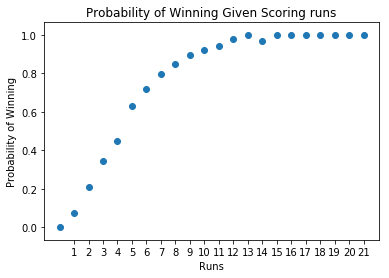

In [15]:
plt.scatter(matchedruns, build)
extraticks=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]
plt.xlabel('Runs')
plt.ylabel('Probability of Winning')
plt.title('Probability of Winning Given Scoring runs')
plt.xticks(extraticks)
plt.show()

In [17]:
newdata= pd.concat([plays["run_dif"], plays["batting_position"], plays["team_won"]], axis=1)
newdata

newrows=[]
for j in range(1,10):
    for i in range(-10,11):
        z=newdata[newdata['run_dif']==i]
        Z=z[z['batting_position']==j]
        percent=np.sum(Z['team_won'])/len(Z)
        newrow=(j, i, percent)
        newrows.append(newrow)
columns1=['Batting Pos', 'Run Differential', 'Win Probability']
finall=pd.DataFrame(newrows, columns=columns1)

matrix = finall.pivot( 'Run Differential','Batting Pos', 'Win Probability')
matrix

Batting Pos,1,2,3,4,5,6,7,8,9
Run Differential,,,,,,,,,
-10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
-7,0.005780,0.002933,0.005797,0.011561,0.011940,0.011628,0.008571,0.005970,0.002959
-6,0.023091,0.024209,0.017375,0.019380,0.018975,0.023622,0.022133,0.030303,0.026465
-5,0.049180,0.046674,0.045506,0.048919,0.048220,0.045238,0.045667,0.042118,0.041162
-4,0.092593,0.093473,0.092639,0.090909,0.085622,0.083736,0.078624,0.075868,0.083333
-3,0.141863,0.140294,0.142540,0.137127,0.127919,0.124190,0.131766,0.133483,0.132488
-2,0.230312,0.231840,0.229735,0.231949,0.222180,0.225181,0.220286,0.212650,0.210965


/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


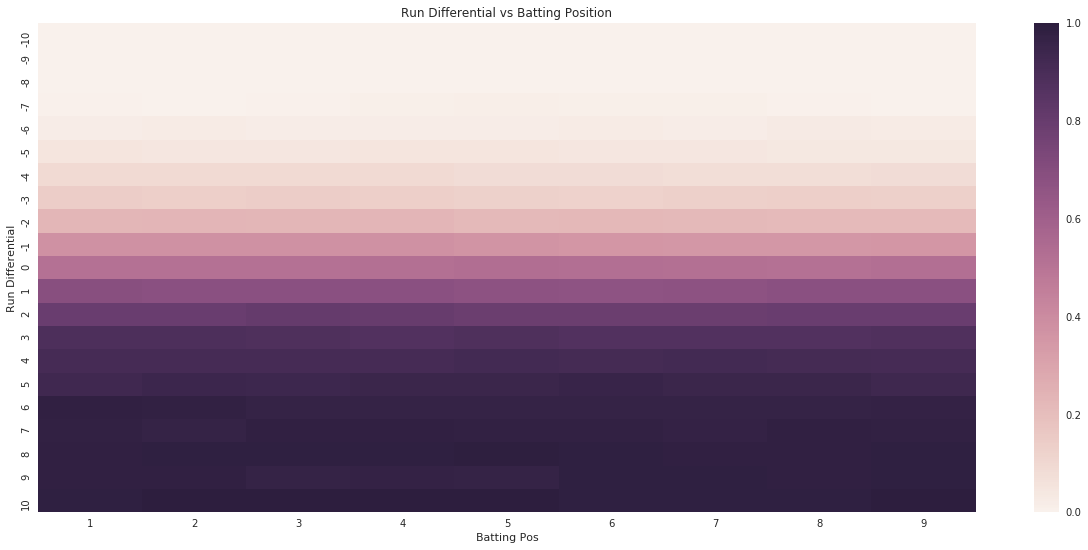

In [18]:
import seaborn as sns
fig = plt.figure(figsize=(21,9))
r = sns.heatmap(matrix)
r.set_title("Run Differential vs Batting Position")
plt.show()

/opt/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


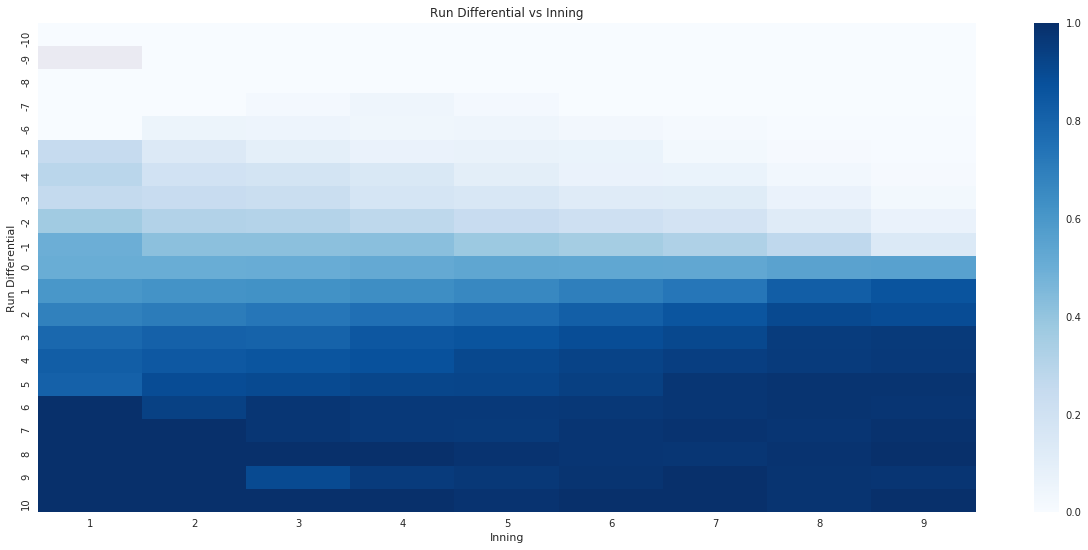

In [20]:
newdata= pd.concat([plays["run_dif"], plays["inning"], plays["team_won"]], axis=1)
newdata

newrows=[]
for j in range(1,10):
    for i in range(-10,11):
        z=newdata[newdata['run_dif']==i]
        Z=z[z['inning']==j]
        if len(Z)==0:
            continue
        
        percent=np.sum(Z['team_won'])/len(Z)
        newrow=(j, i, percent)
        newrows.append(newrow)
columns1=['Inning', 'Run Differential', 'Win Probability']
finall=pd.DataFrame(newrows, columns=columns1)

matrix = finall.pivot( 'Run Differential','Inning', 'Win Probability')
matrix

fig = plt.figure(figsize=(21,9))
r = sns.heatmap(matrix,cmap="Blues")
r.set_title("Run Differential vs Inning")
plt.show()